In [29]:
import matplotlib.pyplot as plt #For plotting our visualizations
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow_decision_forests as tfdf
import cv2
from PIL import Image
import seaborn as sns

# Constants

In [30]:
image_size = (480, 640)
#For setting directory in google colab
%cd /content/Colombian-peso-counterfeit-detection/Lee
!pwd

/content/Colombian-peso-counterfeit-detection/Lee
/content/Colombian-peso-counterfeit-detection/Lee


<hr>

# Load dataset

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "../Data/Original/ds1/Train/",
    image_size=image_size,
    seed=1234,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "../Data/Original/ds1/Test/",
    image_size=image_size,
    seed=1234,
)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    "../Data/Original/ds1/Validation/",
    image_size=image_size,
    seed=1234,
)
class_names = train_ds.class_names


Found 12479 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.
Found 4160 files belonging to 13 classes.


In [32]:
#Add code to reduce size of datasets for faster computations
#remove this code for final runs

## preview data

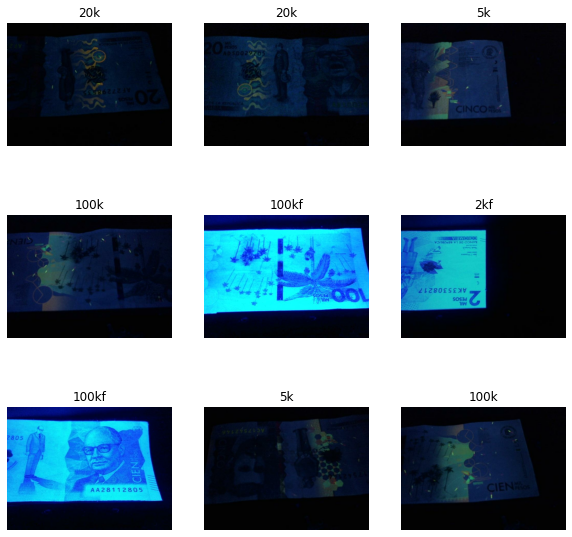

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

## Standardize the data

In [34]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda xx, yy: (normalization_layer(xx), yy))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8313726


<hr/>

# Training

## Allow caching for performance

In [17]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train models and make predictions




In [35]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 480, 640, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
## I was trying this code to make the dataset into np arrays with use on scikit learn
## but it kept using all the RAM
'''train_data = train_ds.unbatch().batch(batch_size=1)
validation_data = validation_ds.unbatch().batch(batch_size=1)

train_data = np.concatenate([x.numpy() for x, _ in train_data], axis=0)
train_labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
validation_data = np.concatenate([x.numpy() for x, _ in validation_data], axis=0)
validation_labels = np.concatenate([y.numpy() for _, y in validation_ds], axis=0)

SyntaxError: ignored

In [51]:
#TFDF random forest model
# Define the model
model = tfdf.keras.RandomForestModel(check_dataset = False)

# Compile the model with sparse categorical crossentropy loss
#model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#  metrics=['accuracy'])


# Train the model on the dataset
model.fit(train_ds)


Use /tmp/tmpo8poaor8 as temporary training directory
Reading training dataset...


Exception: ignored

In [ ]:
#K-nearest neighbors model
k = 20
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(train_ds, validation_ds)
knn_y_pred = knn_model.predict(test_ds)
p_np = np.argmax(predictions, axis=-1)
#Decision tree model
dtree_model = DecisionTreeClassifier()
dtree_model.fit(train_ds, validation_ds)
dtree_y_pred = dtree_model.predict(test_ds)
p_np = np.argmax(predictions, axis = -1)

In [ ]:
#Random forest model
rf_model = RandomForestClassifier()
rf_model.fit(train_ds, validation_ds)
rf_y_pred = rf_model.predict(test_ds)
rf_np = np.argmax(predictions, axis = -1)

In [23]:
#Convolutional neural network model
cnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

cnn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = cnn_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs = 3
)
predictions = model.predict(test_ds)
p_np = np.argmax(predictions, axis=-1)


Epoch 1/3
  3/390 [..............................] - ETA: 1:38:15 - loss: 5.1219 - accuracy: 0.1354

KeyboardInterrupt: ignored

## Confusion Matrix

In [ ]:
test_labels = list(
    test_ds.map(lambda x,y: y)
        .flat_map(tf.data.Dataset.from_tensor_slices)
        .as_numpy_iterator()
)
#test_labels

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(test_labels, p_np)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"pred: {class_names[p_np[i]]} | actual: {class_names[labels[i]]}")
    plt.axis("off")
plt.show()